In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Import the pandas library
import pandas as pd

file_name = "month_data.csv"
# Define the file path
file_path = r"data" + "/" + file_name

# Load the CSV file into a DataFrame
df = pd.read_csv(file_path, sep=';', encoding='utf-8')

# Display the first few rows of the DataFrame
print(df.head())


   Tåguppdrag   Datum_PAU Tågslag Tågsort UppehållstypAvgång  \
0      1710.0  2019-03-23     RST  PENDEL           Uppehåll   
1      1710.0  2019-03-27     RST  PENDEL           Uppehåll   
2      1710.0  2019-03-16     RST  PENDEL           Uppehåll   
3       546.0  2019-03-31     RST   SNABB           Uppehåll   
4      7445.0  2019-03-04     RST  REGION            Passage   

  UppehållstypAnkomst  AktivitetskodAvgång AktivitetskodBeskrivningAvgång  \
0               Sista                   11  Av- och påstigande av resande   
1               Sista                   11  Av- och påstigande av resande   
2               Sista                   11  Av- och påstigande av resande   
3             Passage                   11  Av- och påstigande av resande   
4             Passage                    0                              -   

   AktivitetskodAnkomst AktivitetskodBeskrivningAnkomst  ...  \
0                    10           Avstigande av resande  ...   
1                    10 

In [3]:
import pandas as pd

# List of specific mission types interested in
mission_types = [585,272,584,570,579,269,573,14,17,19,20,22]  # Add or adjust missions as necessary
specific_date = '2019-03-27'  # Change this to desired date
start_time = '7:00:00' 
end_time = '19:00:00'

# Initialize a dictionary to hold routes for each mission
all_routes = {}

all_filtered_data = []  # List to store filtered data for each mission

# Loop through each mission type
for mission_type in mission_types:
    # Filter the DataFrame based on mission type and specific date
    filtered_df = df[(df['Tåguppdrag'] == mission_type) & (df['Datum_PAU'] == specific_date)].copy()
    
    #convert time column to date time format
    filtered_df['PlanAvgTid'] = pd.to_datetime(filtered_df['PlanAvgTid'], errors='coerce')
    filtered_df['PlanAnkTid'] = pd.to_datetime(filtered_df['PlanAnkTid'], errors='coerce')

    #filter by arrival and depature
    filtered_df = filtered_df[((filtered_df['PlanAvgTid'].dt.time >= pd.to_datetime(start_time).time()) & 
                           (filtered_df['PlanAvgTid'].dt.time <= pd.to_datetime(end_time).time())) |
                          ((filtered_df['PlanAnkTid'].dt.time >= pd.to_datetime(start_time).time()) & 
                           (filtered_df['PlanAnkTid'].dt.time <= pd.to_datetime(end_time).time()))]
    
   
    # Append the filtered data to the list
    all_filtered_data.append(filtered_df)

    # Initialize a list to hold the routes for the current mission
    routes = []

    # Step 4: Iterate through filtered DataFrame to build routes
    for index, row in filtered_df.iterrows():
        if row['UppehållstypAvgång'] == 'Första':
            # Start the route with the departure station
            current_route = [row['Avgångsplats']]
            
            # Continue to add stations until reach 'Sista'
            next_row = row
            while next_row['UppehållstypAnkomst'] != 'Sista':
                # Find the next station in the DataFrame that matches the current departure station
                next_station = filtered_df[(filtered_df['Avgångsplats'] == next_row['Ankomstplats']) & 
                                           (filtered_df['Tåguppdrag'] == mission_type)]
                
                if not next_station.empty:
                    current_route.append(next_station.iloc[0]['Ankomstplats'])
                    next_row = next_station.iloc[0]  # Move to the next row
                else:
                    break  # Exit if no further stations are found
            
            # If the last station is 'Sista', append it to the route
            if next_row['UppehållstypAnkomst'] == 'Sista':
                current_route.append(next_row['Ankomstplats'])
            
            # Add the complete route to the routes list
            routes.append(" -> ".join(current_route))
    
    # Store the routes for the current mission in the dictionary
    all_routes[mission_type] = routes

# Combine all filtered data into a single DataFrame
combined_filtered_df = pd.concat(all_filtered_data, ignore_index=True)

# Save the combined filtered DataFrame to CSV
output_file_name = 'network_details.csv'
combined_filtered_df.to_csv(output_file_name, index=False, encoding='utf-8-sig')


# Display the routes for each mission
for mission, routes in all_routes.items():
    print(f"\nRoutes for {mission}:")
    for route in routes:
        print("Route:", route)



# Display the filtered data for the network
print("Filtered data for the network:")
print(combined_filtered_df)

print(f"\nThe output has been saved to {output_file_name}")


Routes for 585:
Route: Umeå -> Gimonäs -> Stöcke -> Norrmjöle -> Hössjön -> Hörnefors -> Ängersjö -> Norrsjön -> Nordmaling -> Rundvik -> Saluböle -> Könsa -> Husums norra -> Husum -> Gideåbacka -> Högbysjön -> Arnäsvall -> Örnsköldsvik Norra -> Örnsköldsviks c -> Gålnäs -> Bjästa -> Drömme -> Hämrasviken -> Harasjön -> Solum -> Västeraspby -> Dynäs -> Kramfors -> Frånö -> Sprängsviken -> Mörtsal -> Svedje -> Härnösand -> Hällenyland -> Häggsjön -> Hussjöby -> Söråkers södra -> Stavreviken -> Solbacka -> Timrå -> Skönvik -> Birsta -> Sundsvalls Västra -> Sundsvall c -> Stockviksverkens nedre -> Svartvik -> Maj -> Gårdsjön -> Årskogen -> Tjärnvik -> Gryttje -> Gnarp -> Åmyran -> Harmånger -> Stegsskogen -> Via -> Hudiksvall -> Iggesund -> Boda -> Myra -> Losesjön -> Källene -> Söderhamn v -> Gussi -> Ljusne -> Vallvik -> Sunnäsbruk -> Axmarby -> Kringlan -> Hamrångefjärden -> Trödje -> Hilleby

Routes for 272:
Route: Linköpings c -> Gistad -> Norsholm -> Kimstad -> Fiskeby -> Norrköpin

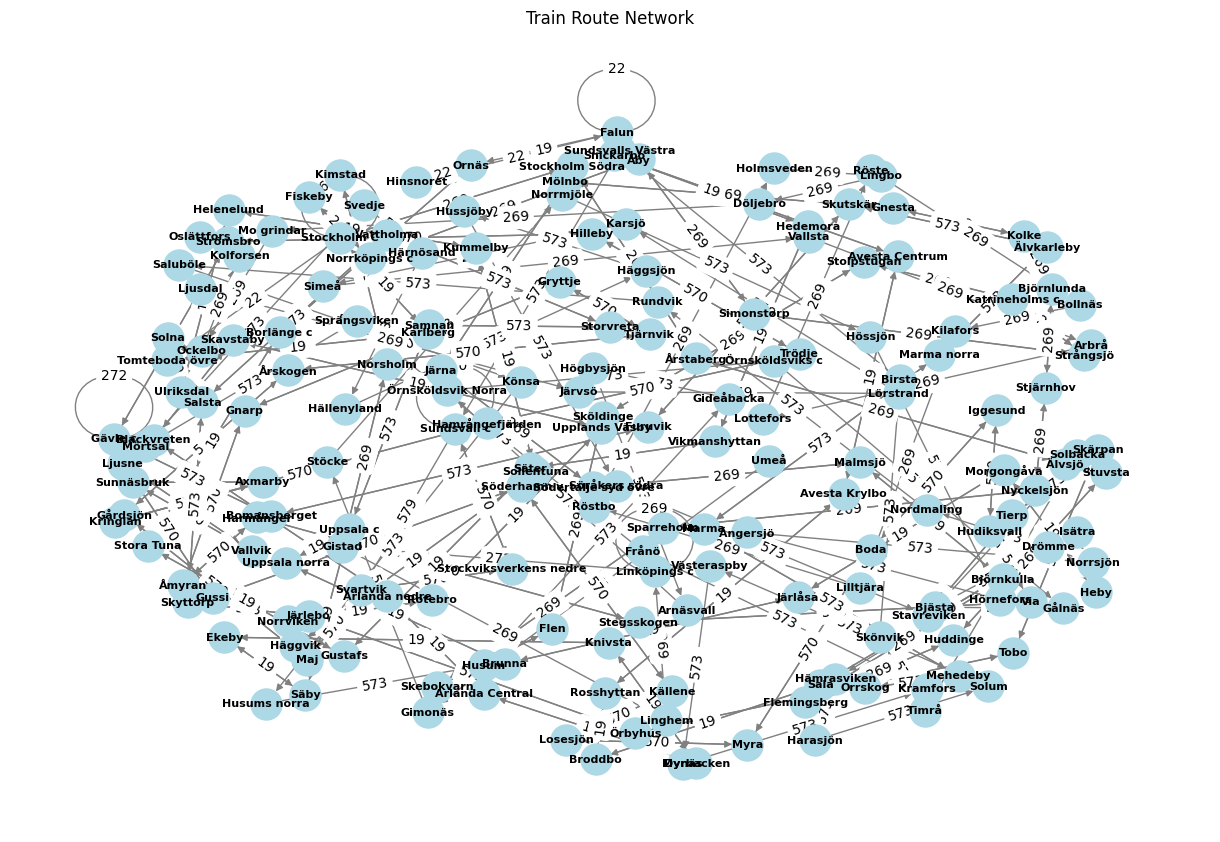

In [4]:
import networkx as nx

G = nx.DiGraph()

# Add edges for each route
for mission, routes in all_routes.items():
    for route in routes:
        stations = route.split(" -> ")
        for i in range(len(stations) - 1):
            G.add_edge(stations[i], stations[i + 1], mission=mission)

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.5)  # positions for all nodes
nx.draw(G, pos, with_labels=True, node_size=500, node_color="lightblue", font_size=8, font_weight="bold", edge_color="gray", arrows=True)

# Show edge labels for mission types
edge_labels = nx.get_edge_attributes(G, 'mission')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title("Train Route Network")
plt.show()
